## <center>情感分析

### <center>1. 朴素贝叶斯

#### 1.1 统计：求先验概率、条件概率

+ 计算每个词出现在pos/neg中的频率
+ 计算先验概率

In [20]:
import random
import jieba


pos_fname = './data/pos.txt'
neg_fname = './data/neg.txt'
stopwords_fname = "./data/stopwords.txt"

pos_sentences = open(pos_fname, encoding='utf-8').read().strip().split('\n')
neg_sentences = open(neg_fname, encoding='utf-8').read().strip().split('\n')
stopwords = open(stopwords_fname, encoding='utf-8').read().strip().split('\n')

def remove_stopwords(_words):
    cnt = 0
    for _ in range(len(_words)):
        if _words[cnt] in stopwords:
            _words.pop(cnt)
        else:
            cnt += 1
    return _words

def load_list_and_dict(pos_sentences, neg_sentences):
    # 得到句子的列表
    random.shuffle(pos_sentences)
    random.shuffle(neg_sentences)

    # 划分训练集和测试集
    TRAIN_SPILT = 0.8
    pos_length = int(len(pos_sentences) * TRAIN_SPILT)
    pos_sent_train = pos_sentences[:pos_length]
    pos_sent_test  = pos_sentences[pos_length:]
    neg_length = int(len(neg_sentences) * TRAIN_SPILT)
    neg_sent_train = neg_sentences[:neg_length]
    neg_sent_test  = neg_sentences[neg_length:]

    # 词汇字典
    pos_word_dict = {}
    neg_word_dict = {}

    print("Building Dict...")
    print("{} sentences in total".format(pos_length+neg_length))
    for sent in pos_sent_train:
        words = remove_stopwords(jieba.lcut(sent, cut_all=True))
        for word in words:
            if word in pos_word_dict.keys():
                pos_word_dict[word] = pos_word_dict[word]+1
            else:
                pos_word_dict[word] = 1

    for sent in neg_sent_train:
        words = remove_stopwords(jieba.lcut(sent, cut_all=True))
        for word in words:
            if word in neg_word_dict.keys():
                neg_word_dict[word] = neg_word_dict[word]+1
            else:
                neg_word_dict[word] = 1
    print("Finished Build")

    lists = [pos_sent_train, pos_sent_test, neg_sent_train, neg_sent_test]
    dicts = [pos_word_dict, neg_word_dict]
    return lists, dicts

#### 1.2 贝叶斯计算：在测试数据上计算准确度

In [21]:
def Bayes(lists, dicts):
    pos_sent_train, pos_sent_test, neg_sent_train, neg_sent_test = lists
    pos_word_dict, neg_word_dict = dicts

    # P(pos) P(neg)
    P_pos = len(pos_sent_train)/(len(pos_sent_train)+len(neg_sent_train))
    P_neg = 1-P_pos


    # pos词的总数与neg词的总数
    pos_total_len = 0
    neg_total_len = 0
    for key in pos_word_dict:
        pos_total_len += pos_word_dict[key]
    for key in neg_word_dict:
        neg_total_len += neg_word_dict[key]


    # Bayes
    rights = 0
    print("Calculating Probability...")
    for sent in pos_sent_test:
        prob_pos = P_pos  # P(pos)
        prob_neg = P_neg  # P(neg)
        words = remove_stopwords(jieba.lcut(sent, cut_all=True))
        for word in words:
            if word in pos_word_dict:
                prob_pos *= pos_word_dict[word]/pos_total_len  # P(w|pos)
            else:
                prob_pos *= 1/pos_total_len                    # P(w|pos)
            if word in neg_word_dict:
                prob_neg *= neg_word_dict[word]/neg_total_len  # P(w|neg)
            else:
                prob_neg *= 1/neg_total_len                    # P(w|neg)
        if prob_pos>=prob_neg:
            rights += 1

    for sent in neg_sent_test:
        prob_pos = P_pos  # P(pos)
        prob_neg = P_neg  # P(neg)
        words = remove_stopwords(jieba.lcut(sent, cut_all=True))
        for word in words:
            if word in pos_word_dict:
                prob_pos *= pos_word_dict[word]/pos_total_len  # P(w|pos)
            else:
                prob_pos *= 1/pos_total_len                    # P(w|pos)
            if word in neg_word_dict:
                prob_neg *= neg_word_dict[word]/neg_total_len  # P(w|neg)
            else:
                prob_neg *= 1/neg_total_len                    # P(w|neg)
        if prob_pos<prob_neg:
            rights += 1
    print("Calculation Finished")

    accuracy = rights/((len(pos_sent_test)+len(neg_sent_test)))
    return accuracy

In [22]:
if __name__ == "__main__":
    lists, dicts = load_list_and_dict(pos_sentences, neg_sentences)
    accuracy = Bayes(lists, dicts)
    print("准确率: {:.2f}%".format(accuracy*100))

Building Dict...
8000 sentences in total
Finished Build
Calculating Probability...
Calculation Finished
准确率: 84.55%


### <center>2.逻辑回归

#### 2.1 生成数据DataLoader

中文分词-->去掉停用词-->词向量编码-->将句子编程词向量的聚合-->sentence&label配对-->词向量&label配对-->生成Dataloader

In [255]:
import torch
from gensim.models import Word2Vec

import numpy as np
from matplotlib import pyplot as plt

import jieba
import random


pos_fname = './标注语料/汇总/pos.txt'
neg_fname = './标注语料/汇总/neg.txt'
stopwords_fname = "./stopwords.txt"
stopwords = open(stopwords_fname, encoding='utf-8').read().strip().split('\n')


def remove_stopwords(input_words):
    cnt = 0
    for _ in range(len(input_words)):
        if input_words[cnt] in stopwords or input_words[cnt].strip() == "":
            input_words.pop(cnt)
        else:
            cnt += 1
    return input_words


def process_data():
    """
    函数功能：读取原始语料。
    :return: 句子 label
    """
    jieba.setLogLevel(jieba.logging.INFO)

    pos_sentence, pos_label, neg_sentence, neg_label = [], [], [], []  # label为1表示积极，label为0表示消极
    
    lines = open(pos_fname, encoding='utf-8').read().strip().split('\n')
    for sent in lines[:3000]:
        words = jieba.lcut(sent, cut_all=True)
        pos_sentence.append(remove_stopwords(words))
        pos_label.append(1)
                
    
    lines = open(neg_fname, encoding='utf-8').read().strip().split('\n')
    for sent in lines:
        words = jieba.lcut(sent, cut_all=True)
        neg_sentence.append(remove_stopwords(words))
        neg_label.append(0)

    sentence = (pos_sentence + neg_sentence)[:]
    label = (pos_label + neg_label)[:]
    shuffle = list(zip(sentence, label))
    random.shuffle(shuffle)  # 打乱数据集
    sentence[:], label[:] = zip(*shuffle)

    return sentence, label


def sent2vec(model, input_sent, vec_size=20, max_sent_len=64):
    """
    函数功能: 将sentence中的词语转换为词向量, 并把句子concat起来
    parameter: model, sentence
    return: sentence_vector
    """
    output_vec = []
    for sent in input_sent:
        vec = []
        sent = sent[:max_sent_len]
        for word in sent:
            if word in model.wv:  # 如果有该词 得到其词向量表示
                vec.append(model.wv[word])               
            else: # 如果字典中未有该词 设置为零向量
                vec.append(np.zeros(vec_size).astype("float32"))
        if(len(sent)<max_sent_len):  # padding 为零向量
            for _ in range(max_sent_len-len(sent)):
                vec.append(np.zeros(vec_size).astype("float32"))
        output_vec.append(np.concatenate(vec))
    return output_vec


def load_data(model, sentence, label, batch_size=32, vec_size=20, train_split=0.8, max_sent_len=64):
    # sentence, label = process_data()
    vec = sent2vec(model, sentence, vec_size, max_sent_len)
    
    length = int(train_split*len(vec))
    train_vec = vec[:length]
    test_vec  = vec[length:]
    train_label = label[:length]
    test_label  = label[length:]

    train_vec = torch.tensor(np.array(train_vec))
    test_vec = torch.tensor(np.array(test_vec))
    train_label = torch.tensor(np.array(train_label))
    test_label = torch.tensor(np.array(test_label))

    train_dataset = torch.utils.data.TensorDataset(train_vec, train_label)
    test_dataset  = torch.utils.data.TensorDataset(test_vec, test_label)
    train_iter    = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
    test_iter     = torch.utils.data.DataLoader(test_dataset,  batch_size, shuffle=False)

    return train_iter, test_iter

#### 2.2 定义模型与训练过程

In [305]:
class LogisticRegression:
    """
    逻辑回归模型
    """
    def __init__(self, word_dim=20, max_len=64, device=torch.device('cpu')):
        # 模型参数保存路径：
        self.weights_path = "./weights.pth"
        self.bias_path = "./bias.pth"

        self.device = device
        self.weights = torch.randn(1, max_len * word_dim)  # 高斯分布
        self.bias = torch.rand(1, 1)*0.2-0.1 # [-0.1, 0.1]的均匀分布
        self.weights = self.weights.to(self.device)
        self.bias = self.bias.to(self.device)


    def sigmoid(self, x):
        y = 1 / (1 + torch.exp(x))
        return y


    def loss(self, y, y_hat):
        self.epsilon = 1e-5
        y_hat = torch.clamp(y_hat, self.epsilon, 1 - self.epsilon)
        cross_entropy_loss = -torch.sum(y*torch.log(y_hat) + (1-y)*torch.log(1-y_hat))/len(y)
        return cross_entropy_loss


    def forward(self, X):
        # X: (batch_size, vec_dim)
        # print("x:",X)
        x = torch.mm(X, self.weights.transpose(0, 1)) + self.bias
        # print("weights:", self.weights)
        # print("bias:", self.bias)
        # print("x*w+b:",x)
        
        y_hat = self.sigmoid(-x)
        
        return y_hat


    def gradient_descent(self, X, y_hat, y, learning_rate=0.0001):
        """
        利用梯度下降调整参数。根据推导出的梯度公式，更新self.weights和self.bias
        :param X: 模型输入
        :param out: 模型输出
        :param y: label值
        :return: None
        """
        y = y.view(-1, 1)
        gradient_w = -torch.sum((y-y_hat)*X, dim=0, keepdim=True)/len(y)
        gradient_b = -torch.sum(y-y_hat,     dim=0, keepdim=True)/len(y)
        self.weights = self.weights - learning_rate * gradient_w
        self.bias    = self.bias    - learning_rate * gradient_b
    

    def adjust_learning_rate(self, lr,decay_rate,decay_step,epoch):
        return lr*(decay_rate**(epoch//decay_step))

    def train(self, train_iter, test_iter, epochs=20, learning_rate=0.0001, decay_rate=0.1, decay_step=10):
        train_losses = []  # 记录平均训练损失
        test_losses = []  # 记录平均测试损失
        test_accs = []
        lr = learning_rate
        for epoch in range(epochs):
            train_loss, n_samples = 0, 0
            for x, y in train_iter:
                x = x.to(self.device)
                y = y.to(self.device)
                y_hat = self.forward(x)
                # print("sidmoid: ", y_hat)
                # print("y: ", y)
                loss_vaule = self.loss(y, y_hat)
                # print("loss:", loss_vaule)
                train_loss +=loss_vaule
                n_samples += len(y)
                self.gradient_descent(x, y_hat, y, lr)
                if (epoch+1)%decay_step==0:
                    lr = self.adjust_learning_rate(lr, decay_rate, decay_step, epoch)
                # break
            # 计算损失
            train_loss /= n_samples
            test_loss = self.test(test_iter)
            acc = self.test_accuracy(test_iter)

            train_losses.append(train_loss.to(torch.device('cpu')))
            test_losses.append(test_loss.to(torch.device('cpu')))
            test_accs.append(acc.to(torch.device('cpu')))
            if epoch%10==0:
                print("epoch{:>3d}/{:>3d} training loss:{:.8f}, test loss:{:.8f}, test accuracy{:.4f}%".format(
                      epoch, epochs, train_loss, test_loss, acc*100))

        return train_losses, test_losses, test_accs


    def test(self, test_iter):
        test_loss, n_samples = 0, 0
        for x, y in test_iter:
            x = x.to(self.device)
            y = y.to(self.device)
            y_hat = self.forward(x)
            # print("sidmoid: ", y_hat)
            # print("y: ", y)
            loss_vaule = self.loss(y, y_hat)
            test_loss += loss_vaule
            n_samples += len(y)
        test_loss /= n_samples
        return test_loss


    def test_accuracy(self, test_iter):
        """
        测试模型分类精度
        :param test_set: 测试集
        :return: 模型精度（百分数）
        """
        rights = 0  # 分类正确的个数
        n_samples = 0
        for x, y in test_iter:
            x = x.to(self.device)
            y = y.to(self.device)
            y_hat = self.forward(x)
            # print("sidmoid: ", y_hat)
            # print("y: ", y)
            rights += torch.sum(torch.abs(y.view(-1, 1)-y_hat)<0.5)
            n_samples += len(y)
        accuracy = rights / n_samples
        return accuracy
    

    def save_param(self):# 保存模型参数
        torch.save(self.weights, self.weights_path)
        torch.save(self.bias,    self.bias_path)


    def load_param(self):# 加载模型参数
        self.weights = torch.load(self.weights_path) 
        self.bias    = torch.load(self.bias_path)



def try_gpu():
    """如果存在则返回gpu, 否则返回cpu"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    return torch.device('cpu')


def draw_loss(train_losses, test_losses):
    epochs = range(1, len(train_losses)+1)
    plt.plot(epochs, train_losses, 'r', label='Train Loss')
    plt.plot(epochs, test_losses, 'b', label='Test Loss')
    plt.legend()

    plt.title('Training and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

def draw_acc(accs):
    epochs = range(1, len(accs)+1)
    plt.plot(epochs, accs, label='Test Accuracy')
    plt.legend()

    plt.title('Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.show()

#### 2.3 训练

epoch  0/200 training loss:4.36715364, test loss:4.34917212, test accuracy55.8333%
epoch 10/200 training loss:3.32016802, test loss:3.42388463, test accuracy64.9167%
epoch 20/200 training loss:2.77988863, test loss:2.87028289, test accuracy66.5833%
epoch 30/200 training loss:2.35073781, test loss:2.43326139, test accuracy68.9167%
epoch 40/200 training loss:2.06191278, test loss:2.12148976, test accuracy69.9167%
epoch 50/200 training loss:1.87276077, test loss:1.93504333, test accuracy70.6667%
epoch 60/200 training loss:1.72569418, test loss:1.79229128, test accuracy71.9167%
epoch 70/200 training loss:1.63701463, test loss:1.69807470, test accuracy72.2500%
epoch 80/200 training loss:1.56333697, test loss:1.62963009, test accuracy72.2500%
epoch 90/200 training loss:1.49855840, test loss:1.55990493, test accuracy73.6667%
epoch100/200 training loss:1.45913351, test loss:1.51948500, test accuracy73.4167%
epoch110/200 training loss:1.41639876, test loss:1.48346663, test accuracy73.8333%
epoc

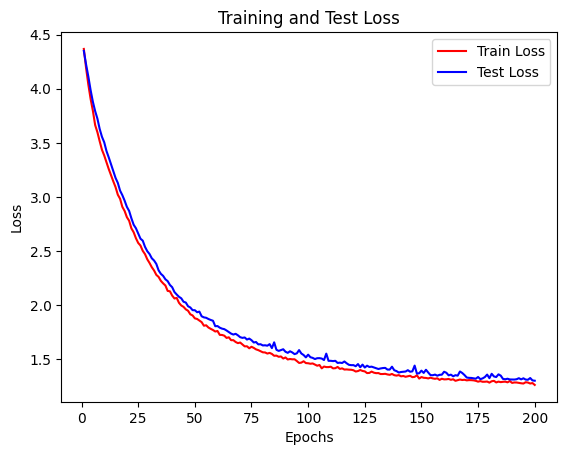

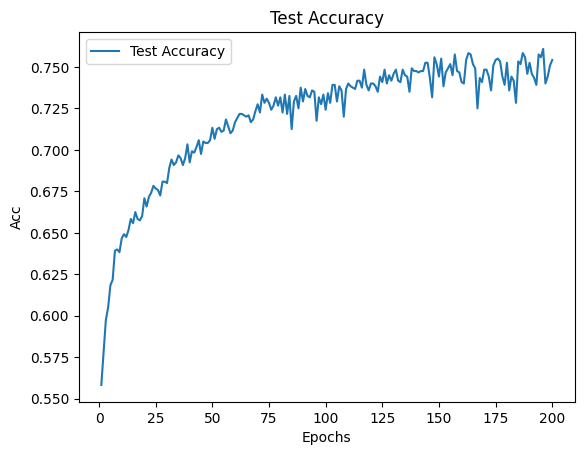

In [309]:
if __name__ == "__main__":
    BATCH_SIZE = 64
    MAX_SENT_LEN = 20
    TRAIN_SPLIT  = 0.8
    VEC_SIZE   = 20
    device = torch.device('cpu')

    # 处理数据
    sentence, label = process_data()
    # 训练词向量模型
    w2v_model = Word2Vec(sentence, vector_size=VEC_SIZE, min_count=1, window=5,sg=0, workers=4)
    w2v_model.save("word2vec_model.model")
    # 如果有现成的模型，可以直接导入
    w2v = Word2Vec.load("word2vec_model.model")

    # 加载训练数据和测试数据
    train_iter, test_iter = load_data(w2v, sentence, label, batch_size=BATCH_SIZE, vec_size=VEC_SIZE, train_split=TRAIN_SPLIT, max_sent_len=MAX_SENT_LEN)

    # 建立模型
    model = LogisticRegression(word_dim=VEC_SIZE, max_len=MAX_SENT_LEN, device=device)

    # 训练模型并记录损失
    train_losses, test_losses, acc = model.train(train_iter, test_iter, epochs=200, learning_rate=0.025, decay_rate=0.8, decay_step=100)

    # 绘制损失曲线&模型精度
    draw_loss(train_losses, test_losses)
    draw_acc(acc)

#### 2.4 测试模型对于任意输入的句子的判断能力

In [358]:
def test_sentence(list, labels, word_model, logist_model, vec_size, max_sent_len):
    for i in range(len(list)):
        sent  = list[i]
        label = labels[i]
        print("-"*20, i+1, "-"*20)
        print("原句字:  ",sent)
        words = remove_stopwords(jieba.lcut(sent, cut_all=True))
        print("使用的词:", words)
        input = [words]
        vector = sent2vec(word_model, input, vec_size, max_sent_len)
        result = logist_model.forward(torch.tensor(vector[0]).view(1, -1))
        if result>=0.5:
            print("预测值:   pos")
        else:
            print("预测值:   neg")
        if label==1:
            print("真实值:   pos")
        else:
            print("真实值:   neg")

        print("Prob:    {:.2f}".format(result.item()))

In [362]:
list = ["标准间太差 房间还不如3星的 而且设施非常陈旧.建议酒店把老的标准间从新改善", 
        "批评！房间也太差了吧",
        "我真的好喜欢这部电影",
        "你真的好美丽啊，我好爱"]
label = [0,0,1,1]
test_sentence(list, label, w2v_model, model, VEC_SIZE, MAX_SENT_LEN)

-------------------- 1 --------------------
原句字:   标准间太差 房间还不如3星的 而且设施非常陈旧.建议酒店把老的标准间从新改善
使用的词: ['标准', '标准间', '太差', '房间', '星', '设施', '陈旧', '建议', '酒店', '标准', '标准间', '新', '改善']
预测值:   neg
真实值:   neg
Prob:    0.04
-------------------- 2 --------------------
原句字:   批评！房间也太差了吧
使用的词: ['批评', '房间', '太差']
预测值:   neg
真实值:   neg
Prob:    0.48
-------------------- 3 --------------------
原句字:   我真的好喜欢这部电影
使用的词: ['真的', '喜欢', '这部', '电影']
预测值:   pos
真实值:   pos
Prob:    0.53
-------------------- 4 --------------------
原句字:   你真的好美丽啊，我好爱
使用的词: ['真的', '美丽', '爱']
预测值:   pos
真实值:   pos
Prob:    0.51
